In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
calls_by_boro = pd.read_csv('../data/monthly_by_tract.csv')

In [3]:
calls_by_boro.head()

complaint_type created_date  1000100.0  1000201.0  1000202.0  \
0    Dirty Conditions   2004-01-31        NaN        NaN        NaN   
1  Water Conservation   2004-01-31        NaN        NaN        NaN   
2                Snow   2004-01-31        NaN        NaN        NaN   
3       Water Quality   2004-01-31        NaN        NaN        NaN   
4          Electrical   2004-01-31        NaN        NaN        NaN   

   1000500.0  1000600.0  1000700.0  1000800.0  1000900.0    ...      \
0        NaN        NaN        NaN        NaN        NaN    ...       
1        NaN        NaN        NaN        NaN        NaN    ...       
2        NaN        NaN        NaN        NaN        NaN    ...       
3        NaN        NaN        NaN        NaN        NaN    ...       
4        NaN        NaN        NaN        NaN        NaN    ...       

   5027706.0  5027900.0  5029102.0  5029103.0  5029104.0  5030301.0  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2        NaN        NaN        NaN        NaN        NaN        NaN   
3        NaN        NaN        NaN        NaN        NaN        NaN   
4        NaN        NaN        NaN        NaN        NaN        NaN   

   5030302.0  5031901.0  5031902.0  5032300.0  
0        NaN        NaN        NaN        NaN  
1        NaN        NaN        NaN        NaN  
2        NaN        NaN        NaN        NaN  
3        NaN        NaN        NaN        NaN  
4        NaN        NaN        NaN        NaN  

[5 rows x 2165 columns]

In [4]:
#reshapes date so that tracts are a now a columns
calls = pd.melt(calls_by_boro, id_vars=['complaint_type', 'created_date'], 
         var_name=['boro_ct201'])
calls.head()

complaint_type created_date boro_ct201  value
0    Dirty Conditions   2004-01-31  1000100.0    NaN
1  Water Conservation   2004-01-31  1000100.0    NaN
2                Snow   2004-01-31  1000100.0    NaN
3       Water Quality   2004-01-31  1000100.0    NaN
4          Electrical   2004-01-31  1000100.0    NaN

In [5]:
calls = calls.rename(columns={'value':'complaint_count'})

In [6]:
calls['boro_ct201'] = calls['boro_ct201'].str[:7]

In [19]:
# do the per tract math
call_volume = calls.groupby(["boro_ct201", "complaint_type"]).agg({'complaint_count':'sum'})

In [29]:
tract_calls = call_volume.unstack().median(axis=1).to_frame()

In [36]:
tract_calls = tract_calls.reset_index().rename(columns={0:'median_complaint'})

In [51]:
tract_calls

boro_ct201  median_complaint
0       1000100               1.0
1       1000201              50.0
2       1000202              80.5
3       1000500               2.0
4       1000600             305.0
5       1000700              77.0
6       1000800             330.0
7       1000900              65.0
8       1001001              13.0
9       1001002              16.5
10      1001200             104.0
11      1001300              82.0
12      1001401              29.0
13      1001402             143.5
14      1001501             119.0
15      1001502             194.0
16      1001600             431.5
17      1001800             645.0
18      1002000              11.0
19      1002100             111.5
20      1002201             196.5
21      1002202             118.0
22      1002400              15.0
23      1002500              16.0
24      1002601             150.5
25      1002602             243.0
26      1002700              38.0
27      1002800             309.5
28      1002900             196.5
29      1003001             327.5
...         ...               ...
2133    5020700             552.5
2134    5020801             141.5
2135    5020803              92.0
2136    5020804              77.0
2137    5021300             285.0
2138    5022300             204.0
2139    5022600             111.0
2140    5022800              26.0
2141    5023100             232.0
2142    5023900             114.5
2143    5024401              83.0
2144    5024402              50.0
2145    5024700             149.5
2146    5024800             137.0
2147    5025100             105.0
2148    5027301              65.5
2149    5027302              83.0
2150    5027702             130.5
2151    5027704              82.0
2152    5027705             154.0
2153    5027706              80.0
2154    5027900              22.0
2155    5029102              62.0
2156    5029103             140.0
2157    5029104             153.0
2158    5030301             137.0
2159    5030302             195.0
2160    5031901              72.0
2161    5031902             289.0
2162    5032300              65.0

[2163 rows x 2 columns]

In [37]:
shpfile = "../data/census_tracts/census2010.shp"
coord_system = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame.from_file(shpfile, crs=coord_system)

In [41]:
tracts = gdf[['boro_ct201', 'geometry']].merge(tract_calls, 
                                left_on = 'boro_ct201', right_on='boro_ct201')

In [45]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as mcm
import matplotlib.ticker as mticker

In [47]:
cmap = mcm.viridis
norm = mcolors.Normalize(vmin=0, 
                         vmax=tract_calls['median_complaint'].max())

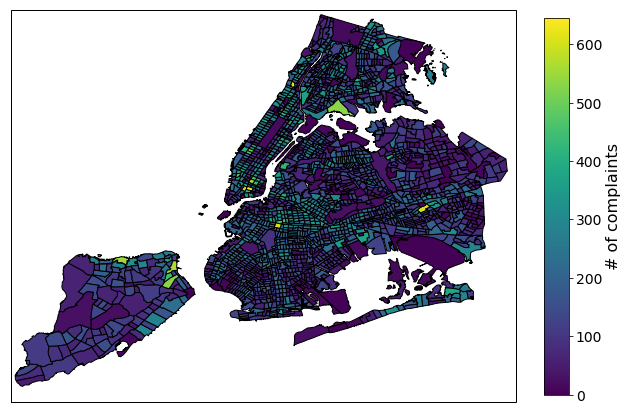

In [50]:
subplot_kw = dict(projection=ccrs.PlateCarree())
fig, ax = plt.subplots(figsize=(10, 10),
                       subplot_kw=subplot_kw)
ax.background_patch.set_visible(False)
#get bounding box for city
#[-73.700272, -74.2590, 40.477399, 40.917577]
ax.set_extent([-73.69, -74.26, 40.477395, 40.92], 
              ccrs.Geodetic())
for _, row in tracts.iterrows():
    color = cmap(norm(row['median_complaint']))
    ax.add_geometries([row['geometry']], subplot_kw['projection'],
                          facecolor=color, edgecolor='black')
    
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=ax, fraction=.045, pad=.05, aspect=15)
cb.ax.tick_params(labelsize=14)
cb.set_label("# of complaints" , fontsize=16)

In [56]:
tract = calls_by_boro[['complaint_type','created_date','1000900.0']]

In [62]:
tc = tract.pivot_table(index='created_date', columns='complaint_type')

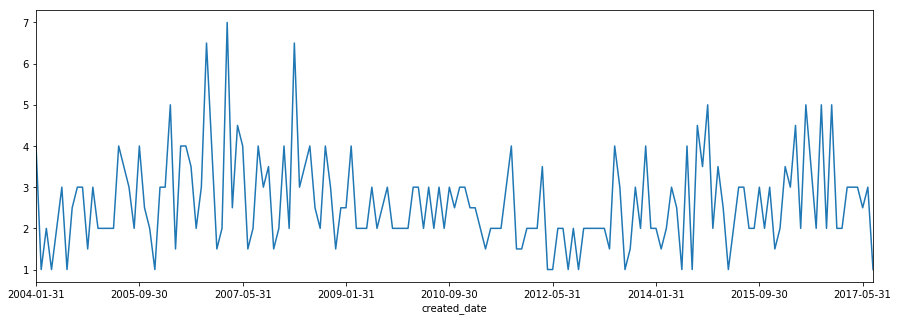

In [67]:
tc.median(axis=1).plot(figsize=(15,5))

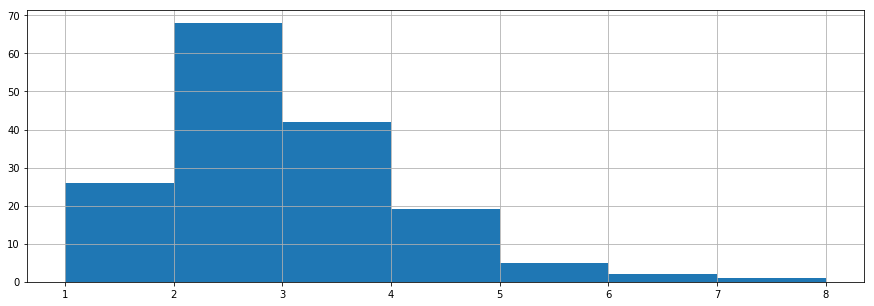

In [69]:
tc.median(axis=1).hist(figsize=(15,5), bins=[1,2,3,4,5,6,7,8])

In [86]:
calls_by_boro.groupby('complaint_type').sum().sum(axis=1).sort_values(ascending=False).index.tolist()

['HEATING',
 'Noise - Residential',
 'PLUMBING',
 'GENERAL CONSTRUCTION',
 'Street Condition',
 'Blocked Driveway',
 'Water System',
 'PAINT - PLASTER',
 'Street Light Condition',
 'Sewer',
 'HEAT/HOT WATER',
 'NONCONST',
 'Noise',
 'General Construction/Plumbing',
 'Noise - Street/Sidewalk',
 'Illegal Parking',
 'ELECTRIC',
 'Dirty Conditions',
 'Sanitation Condition',
 'Noise - Commercial',
 'Building/Use',
 'WATER LEAK',
 'Root/Sewer/Sidewalk Condition',
 'Snow',
 'Electrical',
 'Plumbing',
 'Water Conservation',
 'Water Quality',
 'Non-Residential Heat',
 'Standing Water']

In [ ]:
pd.read